In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ast import literal_eval

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
data_directory = 'dataset/'

def process_data(data_directory):
    interest_topics = pd.read_csv(data_directory + 'interest_topics.csv', index_col='topic_id')
    training_set = pd.read_csv(data_directory + 'training.csv', index_col='userID')
    validation = pd.read_csv(data_directory + 'validation.csv', index_col='userID')

    training_set['ltiFeatures'] = training_set['ltiFeatures'].apply(literal_eval)
    training_set['stiFeatures'] = training_set['stiFeatures'].apply(literal_eval)

    validation['ltiFeatures'] = validation['ltiFeatures'].apply(literal_eval)
    validation['stiFeatures'] = validation['stiFeatures'].apply(literal_eval)

    return interest_topics, training_set, validation

interest_topics, training_set, validation = process_data(data_directory)


In [4]:
# this function makes a wide-form dataframe where each column is a different topic for a userID
def make_topic_table(df, feature_name):
    features = df[feature_name]
    newdf = pd.DataFrame(index=df.index)
    def get_dict_key(dict, key):
        val = dict.get(key)
        if val:
            return val
        else:
            return 0
    for topicID in interest_topics.index:
        newdf[str(topicID)] = [get_dict_key(dict, str(topicID)) for dict in features]

    return newdf


In [5]:
def get_topic_name(topicID):
    return interest_topics.loc[int(topicID), 'topic_name']

class TopicsTree:
    class Node:
        def __init__(self, topic_name=None, topicID=None):
            self.name = topic_name
            self.id = topicID
            self.interest_map = {}
            self.children = {}
    def __init__(self, topics):
        self.head = self.Node()
        self.head.children = {}
        self.makeChildren(topics)
    def makeChildren(self,topics):
        for i in topics.index:
            strArray = topics.loc[i, 'topic_name'].split('/')
            current = self.head
            for str in strArray:
                if not current.children.get(str):
                    current.children[str] = self.Node(topic_name=str)
                current = current.children[str]
            current.id = i
    def get_node(self,topic):
        strArray = topic.split('/')
        current = self.head
        for str in strArray:
            current = current.children.get(str)
            if not current:
                raise KeyError()
        return current
    def get_id(self,topic):
        strArray = topic.split('/')
        current = self.head
        for str in strArray:
            current = current.children.get(str)
            if not current:
                raise KeyError()
        return current.id
    def get_interest(self,topic):
        strArray = topic.split('/')
        current = self.head
        for str in strArray:
            current = current.children.get(str)
            if not current:
                raise KeyError()
        return current.interest_map
    def get_interested_users(self,topic):
        return np.fromiter(self.get_interest(topic).keys(), dtype=int)
    def make_map(self, data, feature_name):
        for userID in data.index:
            def add_users_interest(k,v):
                try:
                    self.get_node(get_topic_name(int(k))).interest_map[userID] = float(v)
                except KeyError:
                    self.head.children[k] = self.Node(topicID=int(k))
            [add_users_interest(k,v) for k,v in data.loc[userID, feature_name].items()]



In [6]:
training_tree = TopicsTree(interest_topics)
training_tree.make_map(training_set, 'ltiFeatures')

validation_tree = TopicsTree(interest_topics)
validation_tree.make_map(validation, 'ltiFeatures')

df_training_conversion_proportion = pd.DataFrame(index=interest_topics.index)
df_training_conversion_proportion['conversion_proportion'] = [
np.mean([training_set.loc[userID, 'inAudience'] for userID in
training_tree.get_interested_users(get_topic_name(i))])
for i in interest_topics.index
]

df_validation_conversion_proportion = pd.DataFrame(index=interest_topics.index)
df_validation_conversion_proportion['conversion_proportion'] = [
np.mean([validation.loc[userID, 'inAudience'] for userID in
validation_tree.get_interested_users(get_topic_name(i))])
for i in interest_topics.index
]


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
df_training_conversion_proportion.dropna().sort_values(by=['conversion_proportion']).tail(15)

,conversion_proportion
topic_id,
845,0.076172
1317,0.078189
898,0.080000
843,0.087838
860,0.089744
1414,0.097938
1616,0.100000
1629,0.100000
1463,0.100000


In [41]:
df_training_conversion_proportion['total'] = [np.sum([training_tree.get_interested_users(get_topic_name(i))]) for i in interest_topics.index ]
df_training_conversion_proportion

,conversion_proportion,total
topic_id,,
3,0.012912,3486441720
5,0.021475,69406797
7,0.018464,952014516
8,0.008961,28224882
11,0.015233,405593216
12,0.019387,78982968
13,0.019134,48865408
14,0.010547,331883692
16,0.014842,3862804259


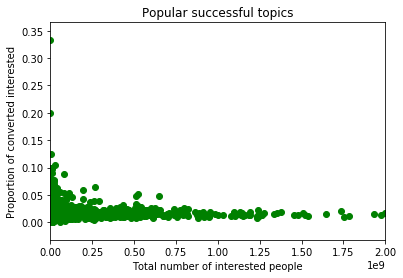

In [44]:
x = df_training_conversion_proportion['total']
y = df_training_conversion_proportion['conversion_proportion']
plt.scatter(x, y, c='green')
plt.title('Popular successful topics')
plt.xlabel('Total number of interested people')
plt.ylabel('Proportion of converted interested')
plt.xlim(30,2*10**9)

plt.show()

count    1394.000000
mean        0.001154
std         0.001201
min         0.000000
25%         0.000683
50%         0.000944
75%         0.001297
max         0.028755
Name: weighted_prop, dtype: float64


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.069e+03, 2.590e+02, 4.600e+01, 8.000e+00, 4.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([0.     , 0.00134, 0.00268, 0.00402, 0.00536, 0.0067 , 0.00804,
        0.00938, 0.01072, 0.01206, 0.0134 , 0.01474, 0.01608, 0.01742,
        0.01876, 0.0201 , 0.02144, 0.02278, 0.02412, 0.02546, 0.0268 ,
        0.02814, 0.02948, 0.03082, 0.03216, 0.0335 , 0.03484, 0.03618,
        0.03752, 0.03886, 0.0402 , 0.04154, 0.04288, 0.04422, 0.04556,
        0.0469 , 0.04

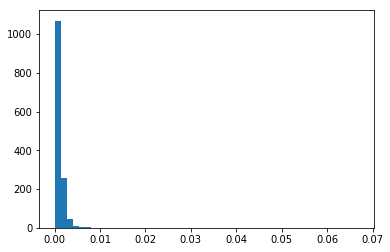

In [70]:
df_training_conversion_proportion['weighted_prop'] = df_training_conversion_proportion['conversion_proportion']/np.log(df_training_conversion_proportion['total'])
print(df_training_conversion_proportion['weighted_prop'].describe())

x = np.asarray(df_training_conversion_proportion['weighted_prop'])

plt.hist(x, range=(0,0.067), bins=50)


In [77]:
print(df_training_conversion_proportion.dropna().sort_values(by=['weighted_prop']).tail(15))
top_weighted_topics = interest_topics.loc[[1625,856,1617,1629,1634,1463,1635,1616,848,1414,898,860,1378,843,336]]
top_weighted_topics

          conversion_proportion     total  weighted_prop
topic_id                                                
336                    0.070175   2264420       0.004796
843                    0.087838  81046731       0.004823
1378                   0.074074   1112875       0.005320
860                    0.089744   7592247       0.005665
898                    0.080000   1038399       0.005775
1414                   0.097938   9337275       0.006102
848                    0.105163  24348388       0.006183
1616                   0.100000    907276       0.007290
1635                   0.100000    554476       0.007561
1463                   0.100000    532714       0.007584
1634                   0.100000    513402       0.007605
1629                   0.100000    443569       0.007691
1617                   0.125000    350669       0.009790
856                    0.200000    222720       0.016242
1625                   0.333333    108263       0.028755


,topic_name
topic_id,
1625,/Sports/Sporting Goods/Squash & Racquetball Eq...
856,/Autos & Vehicles/Motor Vehicles (By Brand)/Pe...
1617,/Sports/Sporting Goods/Cricket Equipment
1629,/Sports/Sporting Goods/Volleyball Equipment
1634,/Sports/Sporting Goods/Combat Sports Equipment...
1463,/Internet & Telecom/Service Providers/Internet...
1635,/Sports/Sporting Goods/Winter Sports Equipment...
1616,/Sports/Sporting Goods/Combat Sports Equipment
848,/Autos & Vehicles/Motor Vehicles (By Brand)/Kia


In [85]:
def top_lads(n):
    return interest_topics.loc[df_training_conversion_proportion.dropna().sort_values(by=['weighted_prop']).tail(n).index].index
top_lads(20)

Int64Index([ 851,  265,  845, 1701, 1317,  336,  843, 1378,  860,  898, 1414,
             848, 1616, 1635, 1463, 1634, 1629, 1617,  856, 1625],
           dtype='int64', name='topic_id')

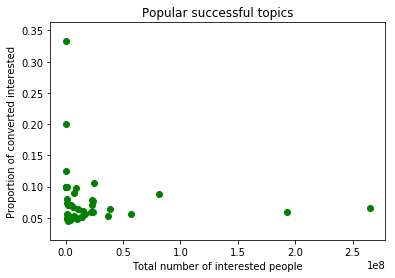

In [86]:
x = df_training_conversion_proportion.loc[top_lads(50)]['total']
y = df_training_conversion_proportion.loc[top_lads(50)]['conversion_proportion']
plt.scatter(x, y, c='green')
plt.title('Popular successful topics')
plt.xlabel('Total number of interested people')
plt.ylabel('Proportion of converted interested')


plt.show()

In [20]:
top_topics = interest_topics.loc[[1625,856,1617,848,1635,1634,1463,1629,1616,1414,860,843,898,1317,845]]
top_topics

,topic_name
topic_id,
1625,/Sports/Sporting Goods/Squash & Racquetball Eq...
856,/Autos & Vehicles/Motor Vehicles (By Brand)/Pe...
1617,/Sports/Sporting Goods/Cricket Equipment
848,/Autos & Vehicles/Motor Vehicles (By Brand)/Kia
1635,/Sports/Sporting Goods/Winter Sports Equipment...
1634,/Sports/Sporting Goods/Combat Sports Equipment...
1463,/Internet & Telecom/Service Providers/Internet...
1629,/Sports/Sporting Goods/Volleyball Equipment
1616,/Sports/Sporting Goods/Combat Sports Equipment


# DONT GO FROM HERE!!###

In [26]:
training_tree.get_interested_users(get_topic_name(856))
#make_topic_table(training_set, 'ltiFeatures')

array([  550, 26457, 54753, 60584, 80376])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train = train_lt
y_train = training_set['inAudience']

X_test = val_lt
y_test = validation['inAudience']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(score)

In [ ]:
train_lt = make_topic_table(training_set, 'ltiFeatures')
train_lt.to_csv(data_directory + 'training_lti_topics.csv')

In [ ]:
train_st = make_topic_table(training_set, 'stiFeatures')
train_st.to_csv(data_directory + 'training_sti_topics.csv')

In [ ]:
val_lt = make_topic_table(validation, 'ltiFeatures')
val_lt.to_csv(data_directory + 'validation_lti_topics.csv')

In [ ]:
val_st = make_topic_table(validation, 'stiFeatures')
val_st.to_csv(data_directory + 'validation_sti_topics.csv')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train = train_lt
y_train = training_set['inAudience']

X_test = val_lt
y_test = validation['inAudience']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(score)

In [ ]:
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32,
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)